In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import time
import json
import scarches as sca
import numpy as np

In [2]:
sc.set_figure_params(figsize=(4, 4))

# Set Params

In [3]:
deep_inject = False
n_epochs_surgery = 500
population = 5

In [4]:
target_batches = ["Freytag"]
batch_key = "condition"
cell_type_key = "final_annotation"

In [5]:
n_epochs_vae = 500
n_epochs_scanvi = 300
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [6]:
# Save right dir path
if deep_inject:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_redone/figure_9/pbmc/scanvi/population_{population}_deep_cond/')
else:
    dir_path = os.path.expanduser(f'~/Documents/benchmarking_redone/figure_9/pbmc/scanvi/population_{population}_first_cond/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
control_path = f'{dir_path}controlling/'
if not os.path.exists(control_path):
    os.makedirs(control_path)

# Adata Handling

In [7]:
if population == 1:
    adata_all = sc.read(
        os.path.expanduser(f'~/Documents/benchmarking_datasets/pbmc_rare/pbmc_rare_1262.h5ad'))
elif population == 2:
    adata_all = sc.read(
        os.path.expanduser(f'~/Documents/benchmarking_datasets/pbmc_rare/pbmc_rare_3619.h5ad'))
elif population == 3:
    adata_all = sc.read(
        os.path.expanduser(f'~/Documents/benchmarking_datasets/pbmc_rare/pbmc_rare_5497.h5ad'))
elif population == 4:
    adata_all = sc.read(
        os.path.expanduser(f'~/Documents/benchmarking_datasets/pbmc_rare/pbmc_rare_7368.h5ad'))
elif population == 5:
    adata_all = sc.read(
        os.path.expanduser(f'~/Documents/benchmarking_datasets/pbmc_rare/pbmc_rare_10161.h5ad'))
adata = adata_all.raw.to_adata()

In [8]:
query = np.array([s in target_batches for s in adata.obs[batch_key]])
adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

In [9]:
sca.dataset.setup_anndata(adata_ref, batch_key=batch_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["condition"]                                           
INFO     Using labels from adata.obs["final_annotation"]                                     
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 28637 cells, 4000 vars, 8 batches,
         16 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


# Create SCVI model and train

In [10]:
vae = sca.models.SCANVI(
    adata_ref,
    "Unknown",
    n_layers=2,
    use_cuda=True,
    encode_covariates=True,
    deeply_inject_covariates=deep_inject,
    use_layer_norm="both",
    use_batch_norm="none",
    use_observed_lib_size=True
)

In [11]:
ref_time = time.time()
vae.train(
    n_epochs_unsupervised=n_epochs_vae,
    n_epochs_semisupervised=n_epochs_scanvi,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)
ref_time = time.time() - ref_time

INFO     Training Unsupervised Trainer for 500 epochs.                                       
INFO     Training SemiSupervised Trainer for 300 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  35%|███▍      | 173/500 [05:13<09:46,  1.79s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  35%|███▍      | 173/500 [05:15<09:55,  1.82s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  217 

# Reference Evaluation

In [12]:
adata_ref.obsm["X_scANVI"] = vae.get_latent_representation()
adata_ref.obs["predictions"] = vae.predict()

In [13]:
ref_cropped = sc.AnnData(adata_ref.obsm["X_scANVI"])
ref_cropped.obs["celltype"] = adata_ref.obs[cell_type_key].tolist()
ref_cropped.obs["batch"] = adata_ref.obs[batch_key].tolist()
ref_cropped.obs["predictions"] = adata_ref.obs["predictions"].tolist()

In [14]:
sc.pp.neighbors(ref_cropped)
sc.tl.leiden(ref_cropped)
sc.tl.umap(ref_cropped)
ref_cropped.write_h5ad(filename=f'{dir_path}reference_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

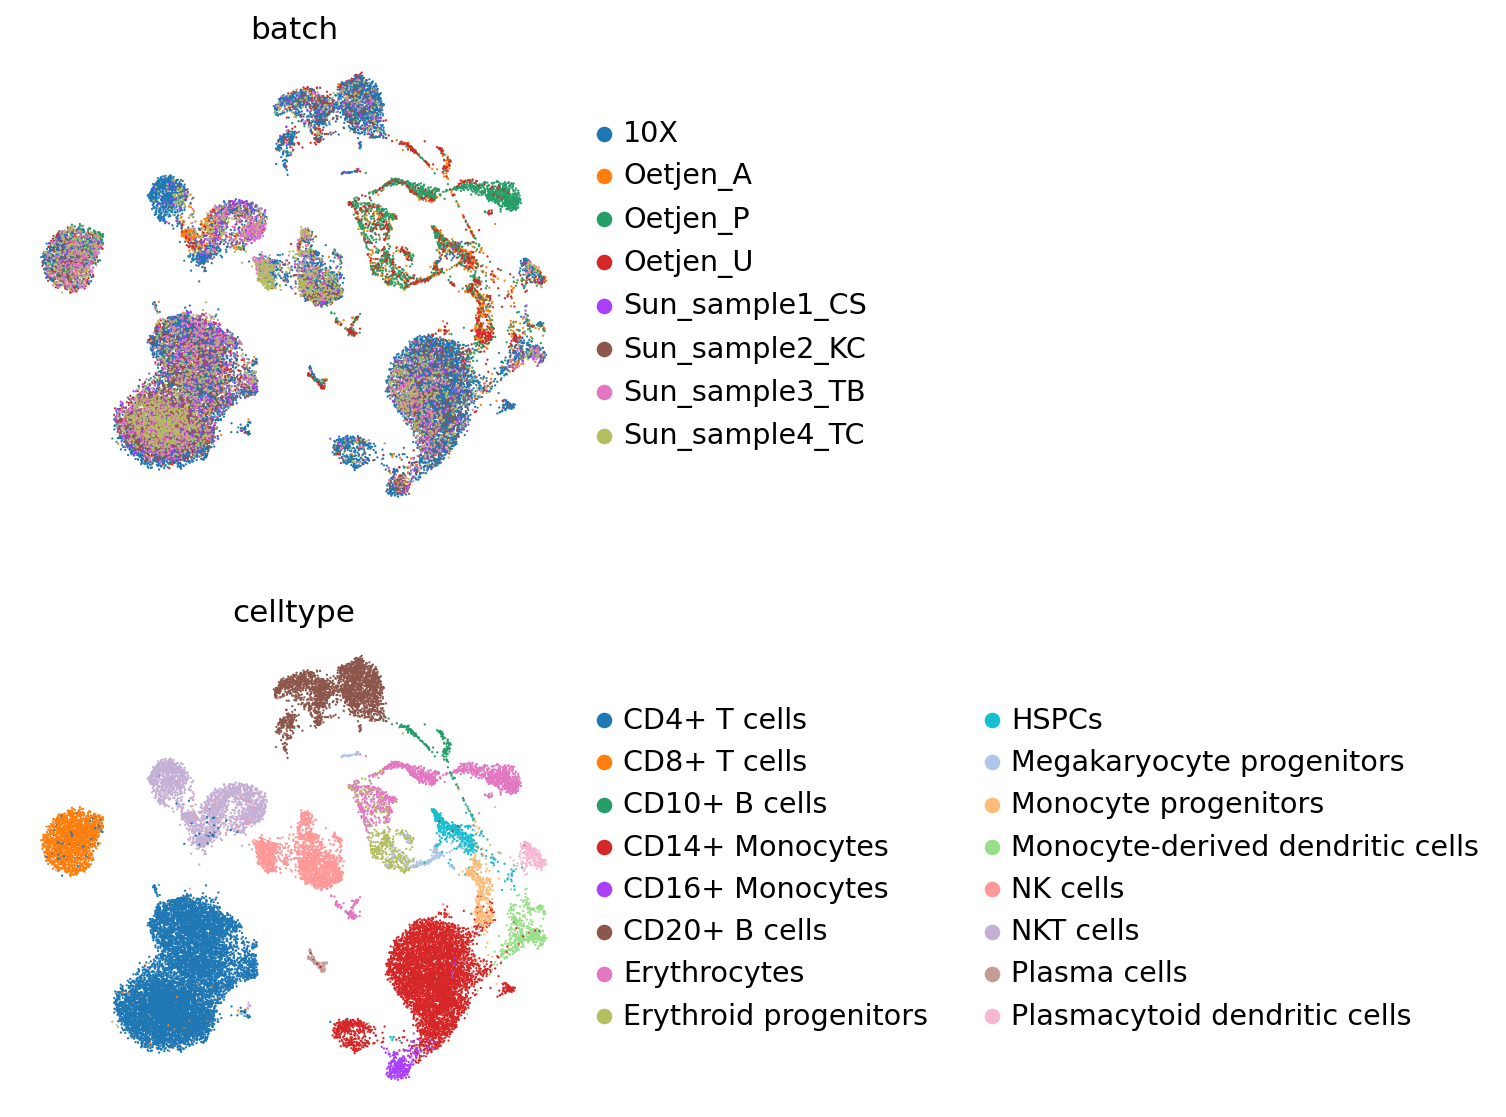

In [15]:
plt.figure()
sc.pl.umap(
    ref_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_reference.png', bbox_inches='tight')

In [16]:
ref_path = f'{dir_path}ref_model/'
if not os.path.exists(ref_path):
    os.makedirs(ref_path)
vae.save(ref_path, overwrite=True)

# Run surgery on query batch

In [17]:
model = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_path,
    freeze_dropout = True,
)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 3347 cells, 4000 vars, 9 batches, 
         16 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


In [18]:
model._unlabeled_indices = np.arange(adata_query.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

Labelled Indices:  0
Unlabelled Indices:  3347


In [19]:
query_time = time.time()
model.train(
    n_epochs_semisupervised=n_epochs_surgery,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"], 
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)
query_time = time.time() - query_time

INFO     Training Unsupervised Trainer for 400 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  12%|█▏        | 61/500 [00:43<05:14,  1.39it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  12%|█▏        | 61/500 [00:44<05:21,  1.36it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  18 s. 

# Evaluation Surgery on Query1

In [20]:
adata_query.obsm["X_scANVI"] = model.get_latent_representation()
adata_query.obs["predictions"] = model.predict()

In [21]:
q_cropped = sc.AnnData(adata_query.obsm["X_scANVI"])
q_cropped.obs["celltype"] = adata_query.obs[cell_type_key].tolist()
q_cropped.obs["batch"] = adata_query.obs[batch_key].tolist()
q_cropped.obs["predictions"] = adata_query.obs["predictions"].tolist()

In [22]:
sc.pp.neighbors(q_cropped)
sc.tl.leiden(q_cropped)
sc.tl.umap(q_cropped)
q_cropped.write_h5ad(filename=f'{dir_path}query_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

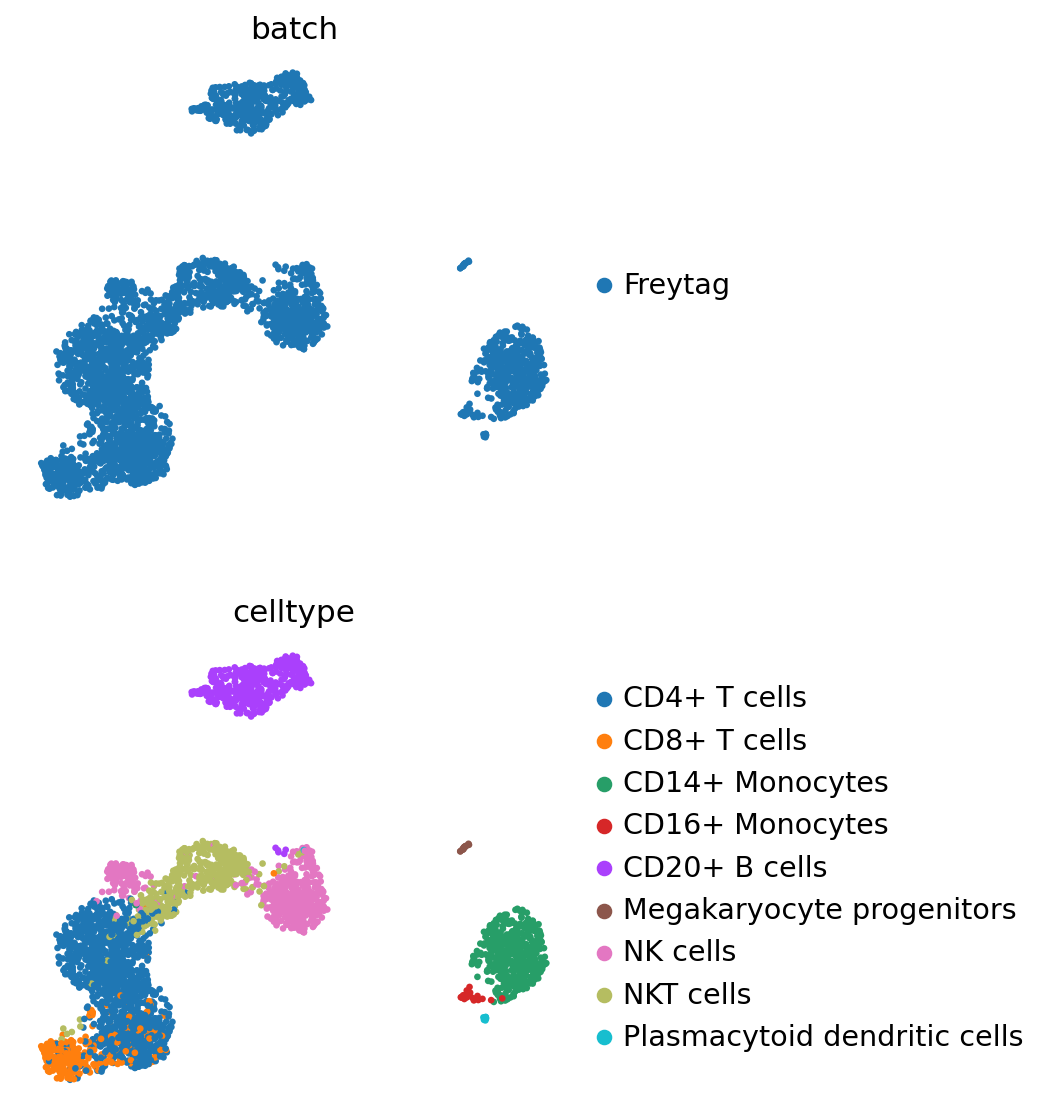

In [23]:
plt.figure()
sc.pl.umap(
    q_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_query.png', bbox_inches='tight')

# Evaluation Query on reference

In [24]:
adata_full = adata_ref.concatenate(adata_query)
adata_full.uns["_scvi"] = adata_query.uns["_scvi"]
adata_full.obsm["X_scANVI"] = model.get_latent_representation(adata=adata_full)
adata_full.obs["predictions"] = model.predict(adata_full)

In [25]:
f_cropped = sc.AnnData(adata_full.obsm["X_scANVI"])
f_cropped.obs["celltype"] = adata_full.obs[cell_type_key].tolist()
f_cropped.obs["batch"] = adata_full.obs[batch_key].tolist()
f_cropped.obs["predictions"] = adata_full.obs["predictions"].tolist()

In [26]:
sc.pp.neighbors(f_cropped)
sc.tl.leiden(f_cropped)
sc.tl.umap(f_cropped)
f_cropped.write_h5ad(filename=f'{dir_path}full_data.h5ad')

... storing 'celltype' as categorical
... storing 'batch' as categorical
... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

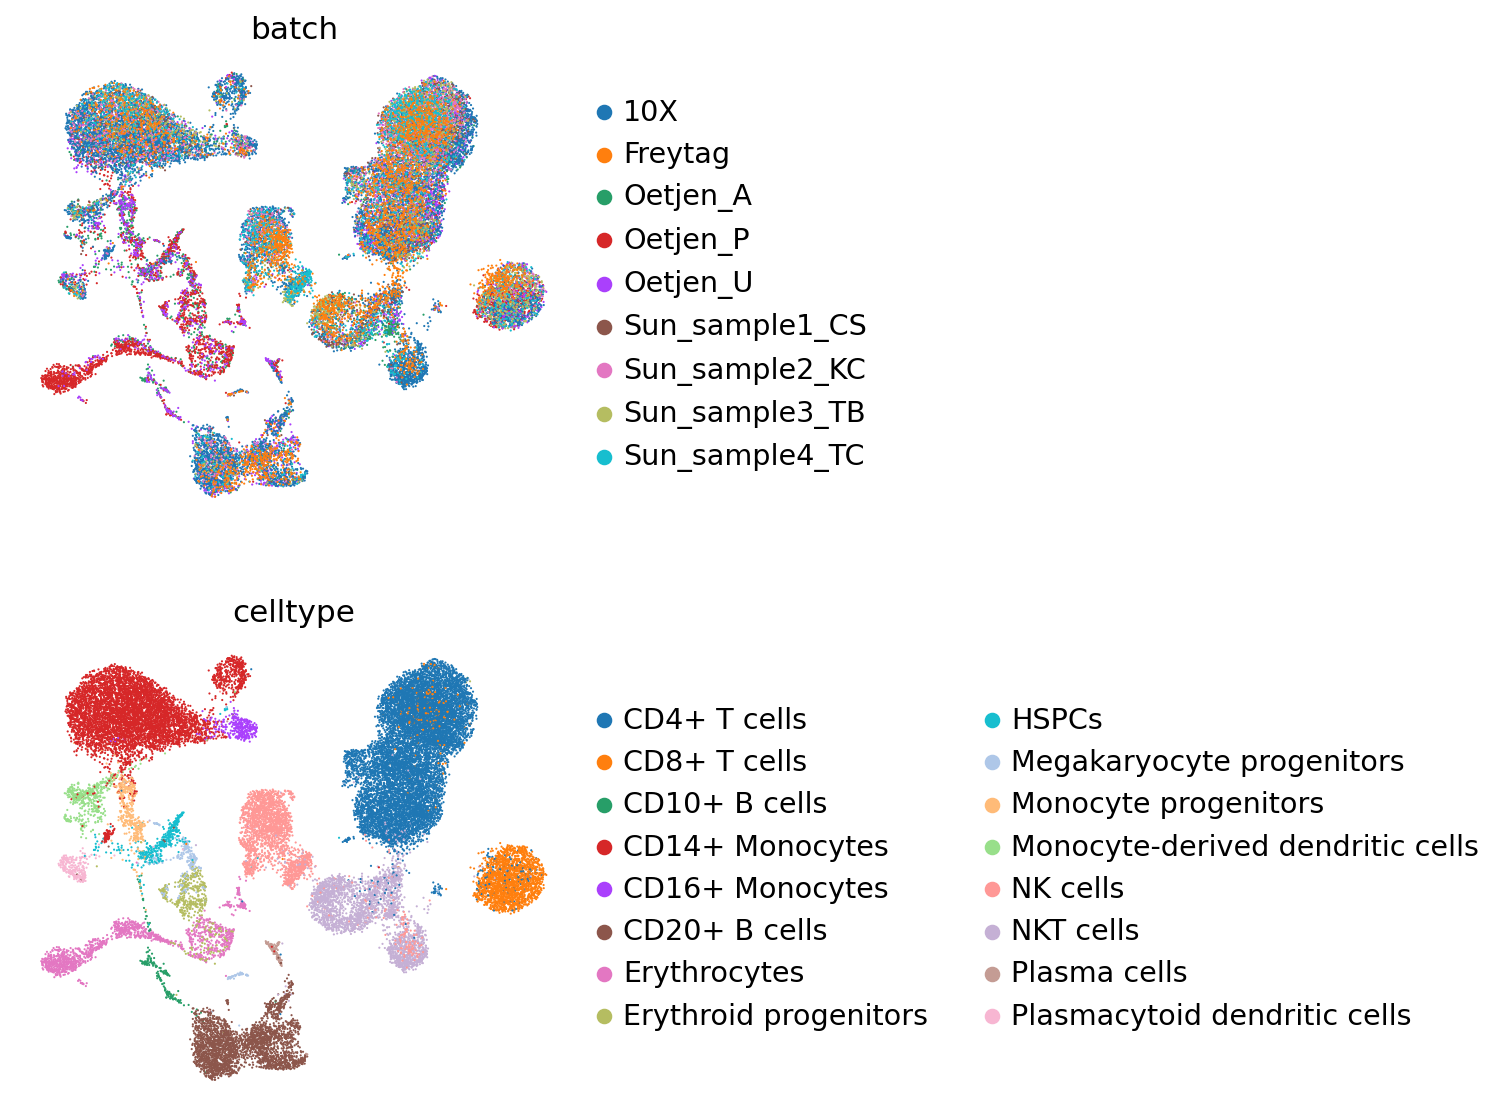

In [27]:
plt.figure()
sc.pl.umap(
    f_cropped,
    color=["batch", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_full.png', bbox_inches='tight')

<Figure size 320x320 with 0 Axes>

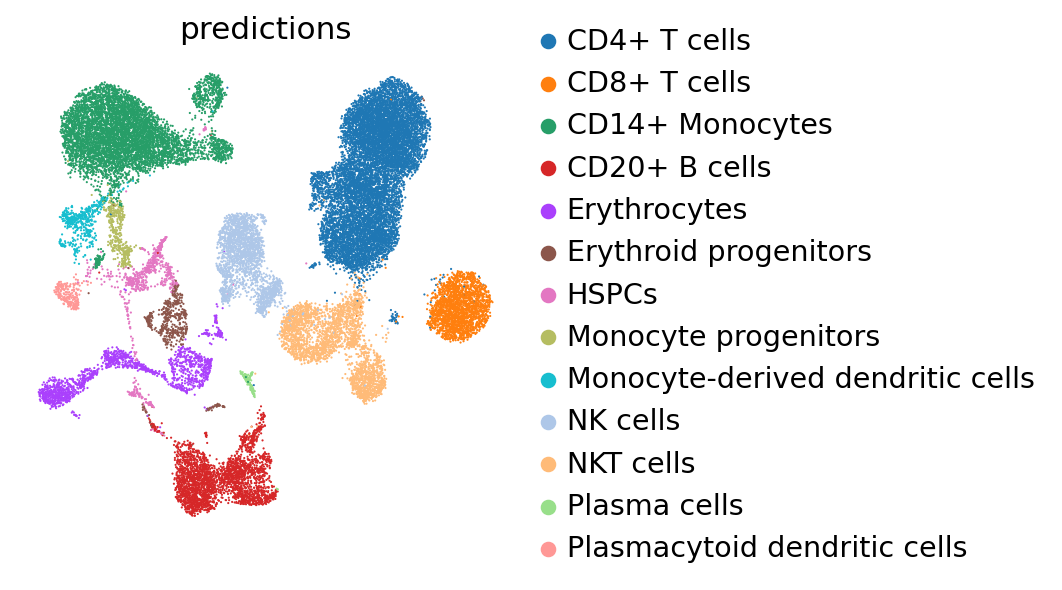

In [28]:
plt.figure()
sc.pl.umap(
    f_cropped,
    color=["predictions"],
    frameon=False,
    ncols=1,
    show=False
)
plt.savefig(f'{control_path}umap_full_pred.png', bbox_inches='tight')

In [29]:
surgery_path = f'{dir_path}surg_model/'
if not os.path.exists(surgery_path):
    os.makedirs(surgery_path)
model.save(surgery_path, overwrite=True)

In [30]:
times = dict()
times["ref_time"] = ref_time
times["query_time"] = query_time
times["full_time"] = ref_time + query_time
with open(f'{dir_path}results_times.txt', 'w') as filehandle:
    json.dump(times, filehandle)